<a href="https://colab.research.google.com/github/hijuliosantos/pos-SR/blob/main/RecomendaLivros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este trabalho tem como objetivo a implementação de um abstrato de sistema de recomendação de livros. Para isto, utilizarei a base de dados disponível no kaggle: https://www.kaggle.com/arashnic/book-recommendation-dataset

</br>

A base possui 3 datasets:


1.   Livros
2.   Usuários
3.   Avaliações dos usuários para os livros

A partir dos datasets, implementarei filtros simples para demonstrar um cold start, filtros baseados em conteúdo e filtros colaborativos. Ambos os filtros serão baseados em memória, não utilizarei filtros baseados em modelo.


## LEITURA DOS DADOS

In [ ]:
#import ipyplot NÃO FUNCIONA BEM COM O COLAB, UTILIZAR COM O JUPYTER
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise as pw
import imutils

from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_usuarios = pd.read_csv('/content/drive/MyDrive/csv/Users.csv',low_memory=False)
df_avaliacoes = pd.read_csv('/content/drive/MyDrive/csv/Ratings.csv',low_memory=False)
df_livros = pd.read_csv('/content/drive/MyDrive/csv/Books.csv',low_memory=False)

df_usuarios.name = 'DF usuários'
df_avaliacoes.name = 'DF avaliações'
df_livros.name = 'Df livros'

## ANÁLISE EXPLORATÓRIA DOS DADOS

#### Avaliar os usuários

Para os usuários, separei o campo "Location" em cidade, estado e país para poder realizar filtros. Também realizei o preenchimento das idades faltantes e de algumas idades que considerei como outliers (não utilizarei idade).

In [ ]:
print('Dataset usuários: ', df_usuarios.shape)
df_usuarios.head()

Dataset usuários:  (278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
df_usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
def check_null_per_column(df):
    print(df.name)
    for column in df:
        print('Coluna', column, 'possui', df[column].isnull().sum().sum(), 'valore nulos')
        
print('Possui dados duplicados?', df_usuarios.duplicated().any())
check_null_per_column(df_usuarios)

Possui dados duplicados? False
DF usuários
Coluna User-ID possui 0 valore nulos
Coluna Location possui 0 valore nulos
Coluna Age possui 110762 valore nulos


In [ ]:
pd.set_option('display.max_rows', 500)
df_usuarios.Age.value_counts()

24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
28.0     5347
29.0     5293
32.0     4781
30.0     4778
22.0     4714
33.0     4699
31.0     4665
34.0     4656
21.0     4438
35.0     4194
20.0     4056
19.0     3950
36.0     3896
18.0     3703
37.0     3582
38.0     3404
39.0     3234
40.0     3142
17.0     3044
41.0     2919
43.0     2816
42.0     2758
44.0     2745
16.0     2570
46.0     2526
45.0     2518
47.0     2512
49.0     2461
15.0     2383
50.0     2340
48.0     2303
51.0     2203
54.0     2140
52.0     2077
53.0     2072
14.0     1962
55.0     1885
57.0     1878
56.0     1692
58.0     1319
59.0     1205
60.0     1125
61.0     1035
13.0      885
62.0      882
63.0      792
64.0      680
65.0      593
66.0      545
67.0      465
68.0      426
0.0       416
69.0      373
70.0      315
1.0       288
71.0      286
72.0      223
73.0      200
12.0      192
104.0     192
74.0      170
11.0      121
75.0      119
76.0      114
2.0       105
10.0       84
77.0  

In [ ]:
df_usuarios.Age.unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [ ]:
print(df_usuarios.Age.describe())

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


limite inferior -6.0
limite superior 74.0


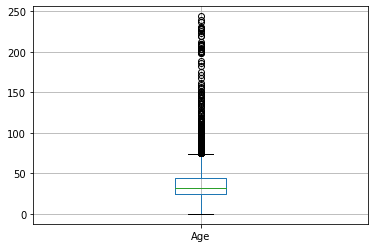

In [ ]:
q1 = 24
q3 = 44
print('limite inferior', q1 - 1.5 * (q3 - q1))
print('limite superior', q3 + 1.5 * (q3 - q1))
df_usuarios.boxplot(column=['Age'])

In [ ]:
df_usuarios.Age.value_counts().index[0] # maior concentração de idades

24.0

In [ ]:
len(df_usuarios)
df_usuarios = df_usuarios[df_usuarios.Age.notnull()]

In [ ]:
df_usuarios.Age.fillna(df_usuarios.Age.value_counts().index[0],inplace=True)
df_usuarios.loc[df_usuarios[df_usuarios.Age == 0].index, 'Age'] = df_usuarios.Age.value_counts().index[0]
df_usuarios.loc[df_usuarios[df_usuarios.Age > 104].index, 'Age'] = df_usuarios.Age.value_counts().index[0]

count    168096.000000
mean         34.727043
std          13.970743
min           1.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         104.000000
Name: Age, dtype: float64


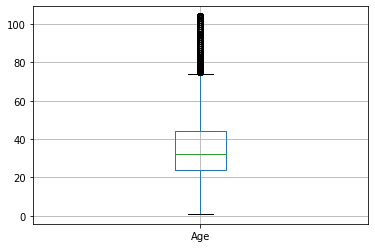

In [ ]:
print(df_usuarios.Age.describe())
df_usuarios.boxplot(column=['Age'])

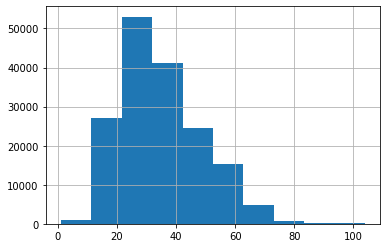

In [ ]:
df_usuarios.Age.hist()

In [ ]:
df_usuarios.head()

,User-ID,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0


In [ ]:
df_usuarios[['City','State','Country']] = df_usuarios.Location.apply(lambda x: pd.Series(str(x).split(",")[0:3]))

In [ ]:
df_usuarios.head()

,User-ID,Location,Age,City,State,Country
1,2,"stockton, california, usa",18.0,stockton,california,usa
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
5,6,"santa monica, california, usa",61.0,santa monica,california,usa
9,10,"albacete, wisconsin, spain",26.0,albacete,wisconsin,spain
10,11,"melbourne, victoria, australia",14.0,melbourne,victoria,australia


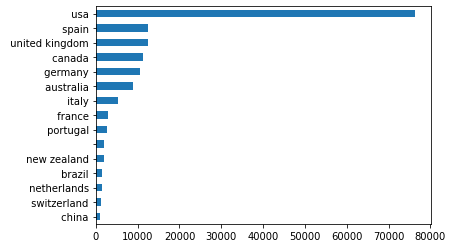

In [ ]:
df_usuarios[df_usuarios.groupby("Country")['Country'].transform('size') > 1000].Country.value_counts().sort_values().plot(kind = 'barh')

#### Avaliar as avaliações
Contém as informações de classificação do livro. As classificações são explícitas, expressas em uma escala de 1 a 10 (valores mais elevados denotando maior valorização), ou implícitas, expressas por 0. Removi as avaliações implícitas, mantendo somente as que foram realmente avaliadas.

In [ ]:
print('Dataset avaliações: ', df_avaliacoes.shape)
df_avaliacoes.head()

Dataset avaliações:  (1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
print('Tem duplicados?', df_avaliacoes.duplicated().any())
print('Tem nulos?', df_avaliacoes.isnull().sum().sum())
check_null_per_column(df_avaliacoes)

Tem duplicados? False
Tem nulos? 0
DF avaliações
Coluna User-ID possui 0 valore nulos
Coluna ISBN possui 0 valore nulos
Coluna Book-Rating possui 0 valore nulos


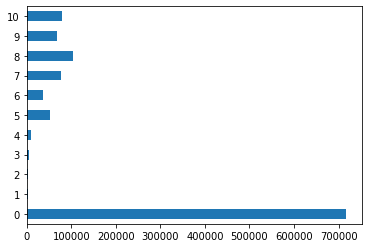

In [ ]:
df_avaliacoes['Book-Rating'].value_counts().sort_index().plot.barh()

In [ ]:
df_avaliacoes['User-ID'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
158698        1
17920         1
277135        1
275086        1
187812        1
Name: User-ID, Length: 105283, dtype: int64

In [ ]:
df_avaliacoes = df_avaliacoes[df_avaliacoes['Book-Rating'] > 0]

#### Avaliar os livros

Para os livros, removi os dados nulos. Removi as colunas de imagens em escala pequena e grande. Notou-se que existem outliers no ano de publicação dos livros. Não modifiquei pois o ideal seria fazer um estudo detalhado.

O dataset dos livros não conta com muitas váriaveis, somente: título, autor, publicador, ano de publicação, foto do livro e imagem. O ideal seria também ter colunas como: prefácio, local de publicação do livro, categoria do livro...

Observação: existem versões de livros para mais países, dependendo de aonde foi publicado. Exemplo Harry Potter Y El Prisionero de Azkaban / Harry Potter and the Prisoner of Azkaban

In [ ]:
print('Dataset livros: ', df_livros.shape)
df_livros.head()

Dataset livros:  (271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
print('duplicados?', df_livros.duplicated().any())
print('nulos?', df_livros.isnull().sum().sum())
check_null_per_column(df_livros)

duplicados? False
nulos? 6
Df livros
Coluna ISBN possui 0 valore nulos
Coluna Book-Title possui 0 valore nulos
Coluna Book-Author possui 1 valore nulos
Coluna Year-Of-Publication possui 0 valore nulos
Coluna Publisher possui 2 valore nulos
Coluna Image-URL-S possui 0 valore nulos
Coluna Image-URL-M possui 0 valore nulos
Coluna Image-URL-L possui 3 valore nulos


In [ ]:
df_livros.drop(['Image-URL-S', 'Image-URL-L'],axis=1, inplace=True)
df_livros['Book-Author'].fillna("Unknown", inplace=True)
df_livros['Publisher'].fillna("Unknown", inplace=True)
print('nulos?', df_livros.isnull().sum().sum())
print('Dataset livros: ', df_livros.shape)

nulos? 0
Dataset livros:  (271360, 6)


In [ ]:
df_livros.Publisher.value_counts()

Harlequin                          7535
Silhouette                         4220
Pocket                             3905
Ballantine Books                   3783
Bantam Books                       3646
                                   ... 
Hope Springs Press.                   1
Modus Vivendi                         1
Mother Road Pubns                     1
Sedmay : distribuidora, Planeta       1
The Ansible Group                     1
Name: Publisher, Length: 16807, dtype: int64

In [ ]:
df_livros['Year-Of-Publication'].value_counts().sort_index()

0                     4618
1376                     1
1378                     1
1806                     1
1897                     1
1900                     3
1901                     7
1902                     2
1904                     1
1906                     1
1908                     1
1909                     2
1910                     1
1911                    19
1914                     1
1917                     1
1919                     1
1920                    33
1921                     2
1922                     2
1923                    11
1924                     2
1925                     2
1926                     2
1927                     2
1928                     2
1929                     7
1930                    13
1931                     3
1932                     5
1933                     4
1934                     1
1935                     3
1936                     7
1937                     5
1938                     7
1939                     9
1

In [ ]:
df_livros.drop(df_livros.loc[(df_livros['Year-Of-Publication'] == 'DK Publishing Inc') | (df_livros['Year-Of-Publication'] == 'Gallimard')].index, inplace=True)
#df_livros.drop(df_livros.loc[df_livros['Year-Of-Publication'] == 0].index, inplace=True)
#df_livros.drop(df_livros.loc[df_livros['Year-Of-Publication'] > 2005].index, inplace=True)
#df_livros.drop(df_livros.loc[df_livros['Year-Of-Publication'] > 2005].index, inplace=True)
#df_livros['Year-Of-Publication'].replace({'0':???},inplace=True)

In [ ]:
df_livros['Year-Of-Publication'].astype(float).describe()

count    271357.000000
mean       1959.760817
std         257.994226
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: Year-Of-Publication, dtype: float64

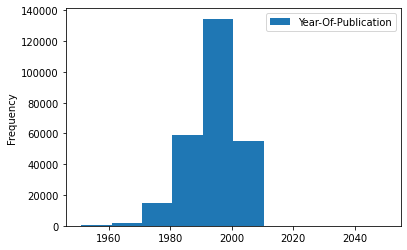

In [ ]:
df_livros['Year-Of-Publication'] = df_livros['Year-Of-Publication'].astype('int')
df_livros[df_livros['Year-Of-Publication'] > 1950].plot.hist()

## SISTEMA DE RECOMENDAÇÃO DE LIVROS

#### COLD START - RECOMENDAÇÕES SIMPLES

Nesta seção, apresento a visualização para um usuário que acabou de iniciar a utilização do sistema. São apresentados os top 10 livros avaliados pelos usuários. A filtragem é realizada de forma simples, basicamente IF/ELSE através da filtragem do pandas. Porém:</br></br>

*Como eu defino o que um livro é top 10?* 
Uma nota nesse dataset pode ser de 1 até 10.

*   Um livro pode ser avaliado uma unica vez e ter uma nota 10 (de 1 até 10)
*   Um livro pode ser avaliado muitas vezes e ter uma nota 9.

</br>

Para a definição, utilizarei quartis para realizar cortes nos dados, filtrando pela quantidade de avaliações dos usuários e a média das avaliações dos usuários com base de X quartis

</br>
Também criei um método para apresentar os top 10 livros avaliados por pessoas do meu país (informação que poderia buscar via dominio do site (en,pt,es...),informada pelo usuário, ip de rede...)


In [ ]:
class ColdStart:
    def __init__(self, country):
        self.country = country
        
    def top_10_books(self):
        # Inicialmente calculo e média de avaliações por livro (Book-Rating) e a quantidade de avaliações (Num-Rating') utilizando o dataset de avaliações.
        # A partir da chave ISBN que liga as avaliações aos livros, obtenho outras colunas para impressão
        avaliacoes_por_livro = pd.DataFrame(df_avaliacoes.groupby('ISBN')['Book-Rating'].mean())
        avaliacoes_por_livro['Num-Rating'] = pd.DataFrame(df_avaliacoes.groupby('ISBN')['Book-Rating'].count())
        avaliacoes_por_livro = avaliacoes_por_livro.merge(df_livros[['ISBN','Book-Title','Book-Author','Publisher','Image-URL-M']], left_on = 'ISBN', right_on = 'ISBN').sort_values('Num-Rating', ascending = False)

        # Utilizo quartis para metrificar o corte na quantidade de avaliações e a média de avaliações. Como existe um número de avaliações não bem distribuidas, utilizo quartil 99% dos dados
        top_10_livros = dict()
        q99 = avaliacoes_por_livro['Num-Rating'].quantile(0.99)
        q3 = avaliacoes_por_livro['Book-Rating'].quantile(0.75)
        print('Num-Rating em 99% dos dados', q99)
        print('Book-Rating em 75% dos dados', q3)
        print('-' * 50)
        print('')
        for livro in avaliacoes_por_livro[(avaliacoes_por_livro['Num-Rating'] >= q99) & (avaliacoes_por_livro['Book-Rating'] >= q3)].sort_values('Book-Rating', ascending = False).iterrows():
            if livro[1]['Book-Author'] not in top_10_livros and len(top_10_livros) != 10:
                top_10_livros[livro[1]['Book-Author']] = (livro[1]['Book-Title'], livro[1]['Image-URL-M'])

        labels = []
        images = []
        for l in top_10_livros:
            labels.append(l + '\n' + top_10_livros[l][0])
            images.append(imutils.url_to_image(top_10_livros[l][1]))

        # CÓDIGO PARA ipyplot
        #images_df = pd.DataFrame()
        #images_df['images'] = images
        #images_df['labels'] = labels    
        #ipyplot.plot_images(images_df['images'],images_df['labels'], max_images=10)

        print('TOP 10 LIVROS RECOMENDADOS')
        _, axs = plt.subplots(4, 3, figsize=(15, 15))
        plt.title = 'TOP 10 LIVROS RECOMENDADOS'
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(images, axs)):
          try:
            ax.axis('off') 
            ax.set_title(labels[i])
            ax.imshow(img)
          except:
            pass
        plt.show()

        del avaliacoes_por_livro
        
    def top_10_books_users_your_country(self):
        # diferentemente do outro método, inicio filtrando pelas avaliações de usuários do país. Utilizao quartis diferentes tbm, devido a alguns países não terem mtos dados
        usuarios_com_pais = df_usuarios[df_usuarios['Country'].notna()]
        usuarios_com_pais = usuarios_com_pais[usuarios_com_pais['Country'] != '']
        avaliacoes_por_pais = df_avaliacoes[df_avaliacoes['User-ID'].isin(usuarios_com_pais[usuarios_com_pais['Country'].str.contains(self.country)]['User-ID'].unique())]

        avaliacoes_por_livro = pd.DataFrame(avaliacoes_por_pais.groupby('ISBN')['Book-Rating'].mean())
        avaliacoes_por_livro['Num-Rating'] = pd.DataFrame(avaliacoes_por_pais.groupby('ISBN')['Book-Rating'].count())
        avaliacoes_por_livro = avaliacoes_por_livro.merge(df_livros[['ISBN','Book-Title','Book-Author','Publisher','Image-URL-M']], left_on = 'ISBN', right_on = 'ISBN').sort_values('Num-Rating', ascending = False)

        top_10_livros = dict()
        print('Q3 Num-Rating', avaliacoes_por_livro['Num-Rating'].describe()['75%'])
        print('Q3 Book-Rating', avaliacoes_por_livro['Book-Rating'].describe()['75%'])
        print('-' * 50)
        print('')
        
        for livro in avaliacoes_por_livro[(avaliacoes_por_livro['Num-Rating'] >= avaliacoes_por_livro['Num-Rating'].describe()['75%']) & (avaliacoes_por_livro['Book-Rating'] >= avaliacoes_por_livro['Book-Rating'].describe()['75%'])].sort_values('Book-Rating', ascending = False).iterrows():
          if livro[1]['Book-Author'] not in top_10_livros and len(top_10_livros) != 10:
            top_10_livros[livro[1]['Book-Author']] = (livro[1]['Book-Title'], livro[1]['Image-URL-M'])

        labels = []
        images = []
        for l in top_10_livros:
            labels.append(l + '\n' + top_10_livros[l][0])
            images.append(imutils.url_to_image(top_10_livros[l][1]))

        # CÓDIGO PARA ipyplot
        #images_df = pd.DataFrame()
        #images_df['images'] = images
        #images_df['labels'] = labels
        #ipyplot.plot_images(images_df['images'],images_df['labels'], max_images=10)

        print('TOP 10 LIVROS COMPRADOS POR OUTROS USUÁRIOS EM SEU PAÍS')
        _, axs = plt.subplots(4, 3, figsize=(15, 15))
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(images, axs)):
          try:
            ax.axis('off') 
            ax.set_title(labels[i])
            ax.imshow(img)
          except:
            pass
        plt.show()

        del avaliacoes_por_livro
    


Num-Rating em 99% dos dados 24.0
Book-Rating em 75% dos dados 9.0
--------------------------------------------------

TOP 10 LIVROS RECOMENDADOS


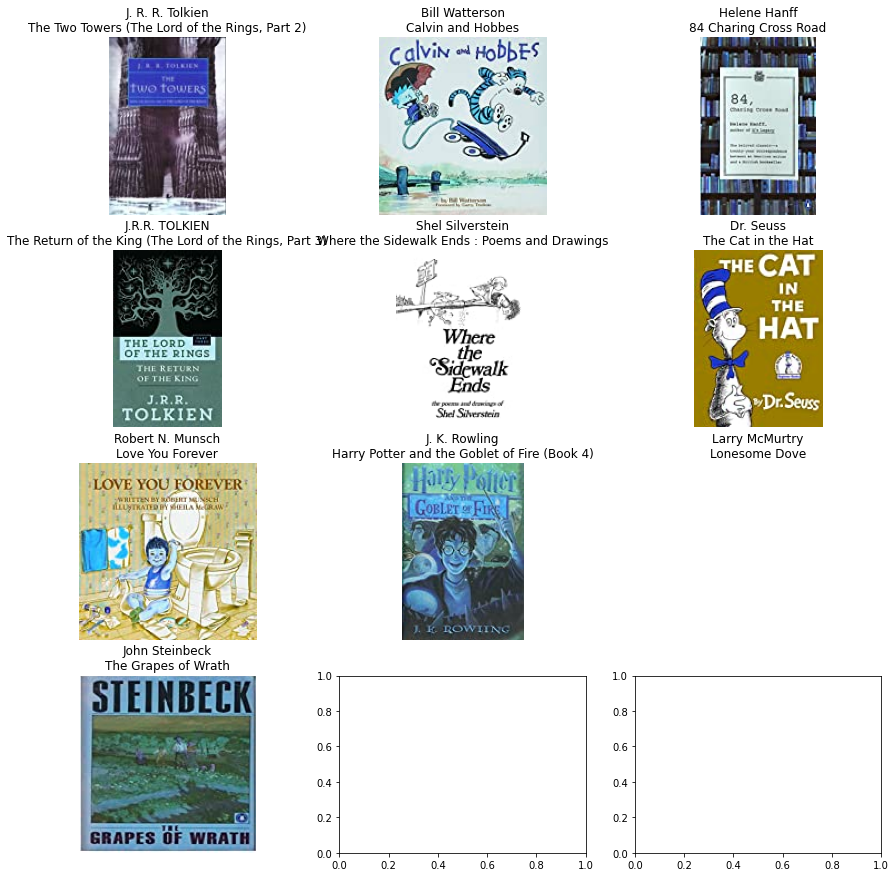

In [ ]:
cold_start = ColdStart('brazil')
cold_start.top_10_books()

Q3 Num-Rating 1.0
Q3 Book-Rating 9.0
--------------------------------------------------

TOP 10 LIVROS COMPRADOS POR OUTROS USUÁRIOS EM SEU PAÍS


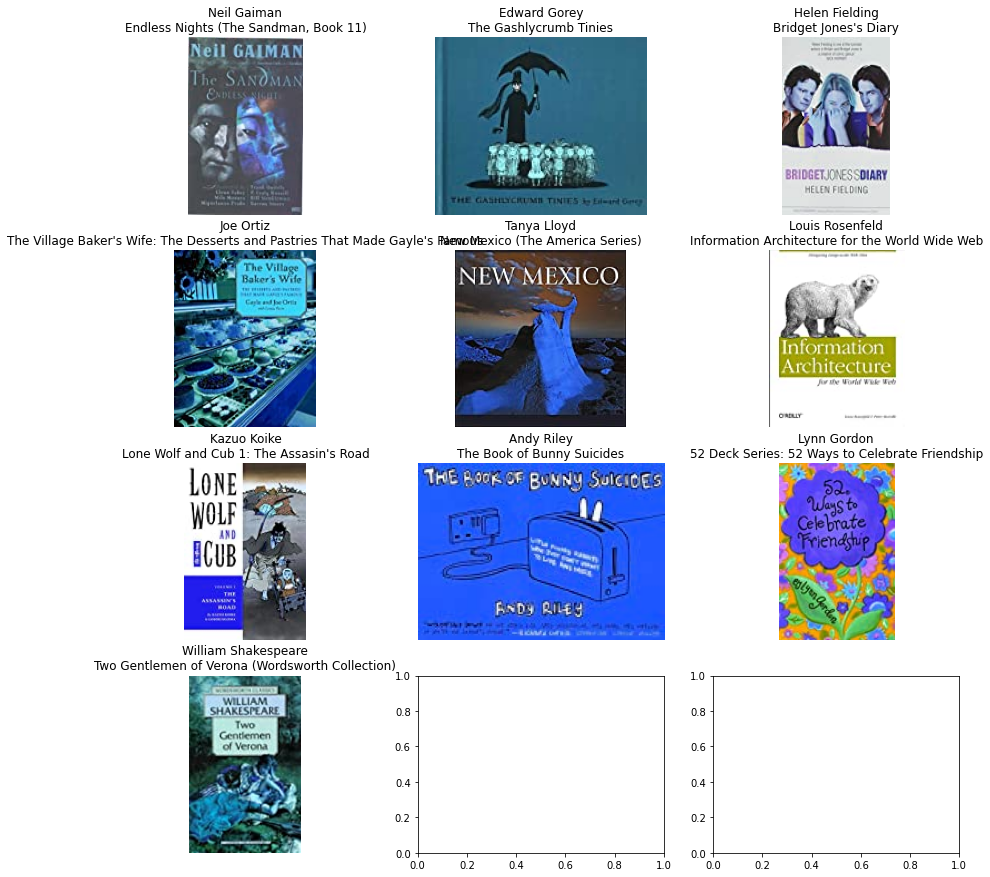

In [ ]:
cold_start.top_10_books_users_your_country()

#### FILTRAGEM BASEADA EM CONTEÚDO

Será implementada uma filtragem de conteúdo baseada em memória para recomendar livros com o nome similar. 

O ideal seria recomendar livros similares com base em prefácios parecidos, porém, o dataset não disponibiliza está informação.

Para realizar a filtragem por conteúdo baseada em memória, será necessário:
- Farei um pré-processamento no nome dos livros, removendo caracteres especiais e deixar o texto em minusculo;
- Utilizar a medida estatistica TF-IDF (term frequency–inverse document frequency - bastante utilizada em PLN) para realizar a transformação no texto e calcular a importância das palavras;
- Utilizar a medida de similaridade dos cossenos para calcular os livros mais parecidos com base no próprio nome do livro;

Como utilizarei um método baseado em memória, por limites da mesma, irei filtrar livros entre um determinado período da data da publicação.

Inicialmente, selecionarei um usuário que possui 10 avaliações e avaliou algum livro do Harry Potter com nota 10 para fins de visualização facilitada nos dados, visto que, existem muitos livros do harry potter e o esperado é trazar vários livros do harry potter. Outro ponto é a base dos dados disponibilizar livros de vários locais, porém, não haver coluna para o país da publicação do livro. Com isto, filtrarei somente por livros avaliados por usuários dos EUA (tbm ajudará da redução dos dados para fins de memória).

In [ ]:
livros_por_avaliacoes_usuarios = pd.merge(df_livros, df_avaliacoes, on="ISBN")
livros_por_avaliacoes_usuarios[(livros_por_avaliacoes_usuarios.groupby("User-ID")['User-ID'].transform('size') == 10) & (livros_por_avaliacoes_usuarios['Book-Title'].str.contains("Harry")) & (livros_por_avaliacoes_usuarios['Book-Rating'] == 10)].head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating
39965,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,3418,10
39980,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,20119,10
40030,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,64344,10
40056,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,86093,10
40151,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,167625,10
40247,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,252829,10
47801,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,252829,10
55379,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,252829,10
59316,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,252829,10
74958,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,252829,10


In [ ]:
pd.options.display.max_colwidth = 100
usuario = 252829
livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios['User-ID'] == usuario]['Book-Title'].unique()

array(["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       "Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'Ultimate Unofficial Guide to the Mysteries of Harry Potter'],
      dtype=object)

In [ ]:
import re

def clean_title(df: pd.DataFrame) -> list:
  cleaned_review = []
  for i in range(df.shape[0]):
    review = df.iloc[i]['Book-Title'].lower()
    review = re.sub('[^a-z0-9]', ' ', review)
    cleaned_review.append(review)
  return cleaned_review

In [ ]:
country = 'usa'
usuarios_com_pais = df_usuarios[df_usuarios['Country'].notna()]
usuarios_com_pais = usuarios_com_pais[usuarios_com_pais['Country'] != '']
avaliacoes_por_pais = df_avaliacoes[df_avaliacoes['User-ID'].isin(usuarios_com_pais[usuarios_com_pais['Country'].str.contains(country)]['User-ID'].unique())]

df_livros_titulo = df_livros[df_livros['ISBN'].isin(avaliacoes_por_pais['ISBN'].unique())]
df_livros_titulo = df_livros_titulo[(df_livros_titulo['Year-Of-Publication'] >= 1999) & (df_livros_titulo['Year-Of-Publication'] <= 2005)] 

df_livros_titulo = df_livros_titulo[['Book-Title', 'Publisher']]
df_livros_titulo = df_livros_titulo.drop_duplicates()
df_livros_titulo.reset_index(drop=True, inplace=True)

#df_livros_titulo["Book-Title-Publisher"] = df_livros_titulo["Book-Title"] + " " + df_livros_titulo["Publisher"]
df_livros_titulo['cleaned_title'] = clean_title(df_livros_titulo)
df_livros_titulo.shape
del avaliacoes_por_pais
del usuarios_com_pais

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_livros_titulo['cleaned_title'])
tfidf_matrix.shape
(10715, 56782)

(10715, 56782)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def map_title(x):
    return df_livros_titulo['Book-Title'].iloc[x]

def fc_livros_similares(df_livros_titulo, cosine_sim, livro):
  mapping = pd.Series(df_livros_titulo.index, index = df_livros_titulo['Book-Title'])
  livro_index = mapping[livro]
  similarity_score = list(enumerate(cosine_sim[livro_index]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
  df_b = pd.DataFrame(similarity_score)
  df_b.columns = ['Book-Title','cosine_sim']
  df_b['Book-Title'] = df_b['Book-Title'].apply(map_title)
  df_b.head(20)
  return df_b.head(20)

In [ ]:
livro = "Harry Potter and the Sorcerer's Stone (Book 1)"
livros = fc_livros_similares(df_livros_titulo, cosine_sim, livro)
livros

,Book-Title,cosine_sim
0,Harry Potter and the Sorcerer's Stone (Book 1),1.000000
1,"Harry Potter and the Sorcerer's Stone (Book 1, Audio)",0.895345
2,Harry Potter and the Sorcerer's Stone (Book 1 Audio CD),0.813794
3,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),0.762131
4,Harry Potter and the Sorcerer's Stone: A Deluxe Pop-up Book,0.647378
5,Harry Potter and the Sorcerer's Stone Movie Poster Book,0.642624
6,Harry Potter and the Goblet of Fire (Harry Potter),0.442782
7,Harry Potter and the Prisoner of Azkaban (Harry Potter),0.415123
8,Harry Potter and the Chamber of Secrets (Harry Potter),0.413915
9,We Love Harry Potter!,0.395177


In [ ]:
print("Como você avaliou positivamente o livro", livro, "recomendamos estes outros livros:\n")
meus_livros = livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios['User-ID'] == usuario]['Book-Title'].unique()
recomendacoes = [print('-', t) for t in livros['Book-Title'].unique() if t not in meus_livros] # somente não exibo os meus que meu usuário já avaliou

Como você avaliou positivamente o livro Harry Potter and the Sorcerer's Stone (Book 1) recomendamos estes outros livros:

- Harry Potter and the Sorcerer's Stone (Book 1, Audio)
- Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)
- Harry Potter and the Sorcerer's Stone: A Deluxe Pop-up Book
- Harry Potter and the Sorcerer's Stone Movie Poster Book
- Harry Potter and the Goblet of Fire (Harry Potter)
- Harry Potter and the Prisoner of Azkaban (Harry Potter)
- Harry Potter and the Chamber of Secrets (Harry Potter)
- We Love Harry Potter!
- Harry Potter and the Prisoner of Azkaban Color and Activity Book (Harry Potter)
- The Sorcerer's Companion: A Guide to the Magical World of Harry Potter
- New Clues to Harry Potter Book 5: Hints from the Ultimate Unofficial Guide to the Mysteries of Harry Potter
- The Magical Worlds of Harry Potter


In [ ]:
del tfidf_matrix
del cosine_sim

#### FILTRAGEM COLABORATIVA

Irei executar a filtragem colaborativa baseada em memória através da medida de similaridade de cossenos (quanto mais próximo de 1 o ângulo do resultado for, mais similares são as minhas comparações). Utilizarei o método disponibilizado no pacote "sklearn". 

Observação: Outros métodos similares de memória poderiam ser utilizados também, como a distancia euclidiana, distancia de manhattan, knn ajustado para aprendizado não supervisionado...

Para a recomendação por filtragem colaborativa, continuarei utilizando o mesmo usuário da última filtragem. Para fins de visualização e diminuição de dados (devido a limites na memória), utilizarei apenas usuários com 10 avaliações.

In [ ]:
pd.options.display.max_colwidth = 100
livros_por_avaliacoes_usuarios = pd.merge(df_livros, df_avaliacoes, on="ISBN")
livros_por_avaliacoes_usuarios = livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios.groupby("User-ID")['User-ID'].transform('size') == 10]
livros_por_avaliacoes_usuarios

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating
16,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,208059,6
22,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,115097,7
28,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,213191,8
69,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.01.MZZZZZZZ.jpg,44663,8
128,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.01.MZZZZZZZ.jpg,130784,8
...,...,...,...,...,...,...,...,...
382073,1586637118,Zen Reflections,Robert Allen,2002,Friedman/Fairfax,http://images.amazon.com/images/P/1586637118.01.MZZZZZZZ.jpg,233196,7
382114,0451518810,Barchester Towers,Anthony Trollope,1984,New Amer Library Classics,http://images.amazon.com/images/P/0451518810.01.MZZZZZZZ.jpg,233731,8
382730,0786814446,Funny Boy Verses the Bubble-Brained Barbers from the Big Bang (L.a.F. Books),Dan Gutman,2000,Hyperion Books for Children,http://images.amazon.com/images/P/0786814446.01.MZZZZZZZ.jpg,238921,7
383130,0373193173,"And Cowboy Makes Three (Silhouette Romance , No 1317)",Martha Shield,1998,Silhouette,http://images.amazon.com/images/P/0373193173.01.MZZZZZZZ.jpg,241306,7


##### Colaborativa baseada em usuário-usuário

Ajusto os dados conforme devem ser passados para o método do skelarn cosine_similarity e gero um dataframe para facilitar a visualização

In [ ]:
#https://github.com/jailsonpj/SR/tree/master/sistema/baseadoItens
pivot_user_based = livros_por_avaliacoes_usuarios.pivot_table(index="User-ID", columns="Book-Title", values="Book-Rating").fillna(0)
sparse_pivot_ub = sparse.csr_matrix(pivot_user_based.fillna(0))
#usuarios_recomendados = pw.euclidean_distances(sparse_pivot_ub)
usuarios_recomendados = pw.cosine_similarity(sparse_pivot_ub)
df_recomendacao_baseada_usuarios = pd.DataFrame(usuarios_recomendados, columns=pivot_user_based.index.values, index=pivot_user_based.index.values)
pivot_user_based.shape

(608, 5023)

##### Exemplo das estruturas brutas.  
- da pivot table (tabela dinamica) com o indice sendo os usuários, as colunas os livros e os valores as avaliações. 
- da matriz esparsa
- da matriz com a distancia dos cossenos

In [ ]:
print(pivot_user_based.index.get_loc(usuario))
pivot_user_based[pivot_user_based.index.values == usuario]

554


Book-Title,10 Lb. Penalty,100 Best Honeymoon Resorts of the World (The 100 Best Resorts Series),"101 Survival Secrets: How to Make $1,000,000, Lose 100 Pounds, and Just Plain Live Happily",101 Uses for a Lab,1812 (The American Story),1916: A Novel of the Irish Rebellion (Irish Century),1984,1st to Die: A Novel,20 Hot Potatoes Christians Are Afraid To Touch,"20,001 Names For Baby : Revised and Updated",204 Rosewood Lane,22 Indigo Place,24 Days: How Two Wall Street Journal Reporters Uncovered the Lies that Destroyed Faith in Corporate America,24 Hours,2nd Chance,3 Blind Mice How the TV Networks Lost Their Way,31 days of Praise,311 Pelican Court,"365 Ways to Wok: Stir-Fries, Stews, Sautees",3rd Degree,4 Blondes,48 Hours to a Healthier Life,48 shades of brown,500 Terrific Ideas for Organizing Everything,52 Ways to Simplify Your Life (52 Decks),7 Habits Of Highly Effective People Cd,"76 Ways to Get Organized for Christmas: And Make It Special, Too",871 Famous Last Words,9-11,A &amp; R: A Novel,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 2nd Helping of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit,A Bend in the Road,A Body in the Bath House,A Book of Luminous Things: An International Anthology of Poetry,A Book of Pagan Prayer,A Bride for Donnigan (Women of the West (Paper)),A Bride for Donnigan (Women of the West Series),A Broken Vessel,A CRIME FOR CHRISTMAS NANCY DREW &amp; HARDY BOYS SUPERMYSTERY (Nancy Drew Hardy Boys Super Mystery),A Cafe on the Nile,A Case of Need,A Cat on the Bus: An Alice Nestleton Mystery (Alice Nestleton Mystery Series),A Century of Great Western Stories,A Certain Justice (Adam Dalgliesh Mysteries (Paperback)),"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Code for Tomorrow,A Cold Day in Paradise (Alex McKnight Mysteries (Paperback)),A Cold Heart: An Alex Delaware Novel,...,WÃ?Â¼hler. Zweiter Roman der Nomen- Trilogie.,WÃ?Â¼stenblume.,X Files YA #06 Fresh Bones (X Files YA),X Files YA #07 Control (X Files YA),X-Men 2: A Novelization,"X/1999, Vol. 1, Prelude","XML in a Nutshell, 2nd Edition",Xanth 13: Isle of View,Year of Impossible Goodbyes,Year of Wonders,Year's Best SF 7,Yearling,Yeats: Romantic Visionary (Illustrated Poetry Series),Yellow Dog,Yes!,Yo Me He Llevado Tu Queso,"Yo, el intruso (ColecciÃ³n Autores espaÃ±oles e hispanoamericanos)",You Have The Right To Remain Silent,You Have To Kiss A Lot Of Frogs,You Just Don't Duct Tape a Baby!: True Tales and Sensible Suggestions from a Veteran Pediatrician,You Just Don't Understand,You Only Die Twice: A Novel,You Remind Me of You: A Poetry Memoir (Push Poetry),You Shall Know Our Velocity,Your Baby and Child: From Birth to Age Five,Your First Year as a Nurse: Making the Transition from Total Novice to Successful Professional,Your Money or Your Life: Transforming Your Relationship With Money and Achieving Financial Independence,Your Own Worst Enemy : Breaking the Habit of Adult Underachievement,Yukon Ho!,YÃ¡iza,ZOMBIES GENE POOL,Zen Attitude,Zen Reflections,"Zen and the Art of Knitting: Exploring the Links Between Knitting, Spirituality, and Creativity",Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zen and the art of Motorcycle Maintenance,Zlata's Diary: A Childs Life in Sarajevo,Zuiderkruis: Roman,Zweimal ist einmal zuviel.,"\ Civil Disobedience\"" and \""Reading\"" (Penguin Classics 60s)""","\But I Wouldn't Want to Live There!\"": Wicked Wisdom from Seasoned Travelers""","\O\"" Is for Outlaw""","\Soleil De Soufre\"" Et Autres Nouvelles""","\The Happy Prince\"" and Other Stories (Penguin Popular Classics)""","\The Little Regiment\"" and Other Civil War Stories (Dover Thrift Editions)""","\What Do You Care What Other People Think?\"": Further Adventures of a Curious Character""","designing web graphics.4, Fourth Edition",how to stop time : heroin from A to Z,iI Paradiso Degli Orchi,stardust
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [ ]:
print(sparse_pivot_ub[554])

  (0, 1627)	10.0
  (0, 1629)	10.0
  (0, 1630)	10.0
  (0, 1632)	10.0
  (0, 1634)	10.0
  (0, 1635)	10.0
  (0, 4696)	10.0


In [ ]:
usuarios_recomendados[554]

array([0.        , 0.        , 0.        , 0.15775932, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14378446, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14105509,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10846523, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Método responsável por realizar a recomendação dos usuários similares, a partir do cálculo da similaridade do cosseno. A partir do cálculo, somente obtenho os usuários. Para pegar os livros, tenho que realizar buscas no dataset.



In [ ]:
def fc_usuarios_similares(livros_por_avaliacoes_usuarios, df_recomendacao_baseada_usuarios, usuario):
  df_usr_cosine = pd.DataFrame(df_recomendacao_baseada_usuarios[usuario].sort_values(ascending=False))
  df_usr_cosine.reset_index(level=0, inplace=True)
  df_usr_cosine.columns = ['User-ID','cosine_sim']
  print(df_usr_cosine.head(5))
  meus_livros = livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios['User-ID'] == df_usr_cosine.iloc[0]['User-ID']]['Book-Title'].unique()
  primeiro_usuario_livros = livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios['User-ID'] == df_usr_cosine.iloc[1]['User-ID']]['Book-Title'].unique()
  segundo_usuario_livros = livros_por_avaliacoes_usuarios[livros_por_avaliacoes_usuarios['User-ID'] == df_usr_cosine.iloc[2]['User-ID']]['Book-Title'].unique()
  return meus_livros, primeiro_usuario_livros, segundo_usuario_livros


In [ ]:
usuario = 252829
meus_livros, primeiro_usuario_livros, segundo_usuario_livros = fc_usuarios_similares(livros_por_avaliacoes_usuarios, df_recomendacao_baseada_usuarios, usuario)

   User-ID  cosine_sim
0   252829    1.000000
1   275401    0.652723
2   190448    0.482254
3    66487    0.422522
4   103577    0.413626


In [ ]:
meus_livros

array(["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       "Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'Ultimate Unofficial Guide to the Mysteries of Harry Potter'],
      dtype=object)

In [ ]:
primeiro_usuario_livros

array(['Wild Animus', "Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'Harry Potter and the Goblet of Fire (Book 4)', 'No Greater Love',
       'Four Past Midnight', 'Insomnia: A novel', "Skinner's Festival"],
      dtype=object)

In [ ]:
segundo_usuario_livros

array(['The Mists of Avalon',
       "Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Spilling Clarence: A Novel', 'The Fiery Cross',
       'Dragonfly in Amber', 'Drums of Autumn', 'Voyager'], dtype=object)

In [ ]:
print("Usuários como você também compraram:\n")
recomendacoes = [print ('-', t) for t in (set(meus_livros) ^ set([*primeiro_usuario_livros, *segundo_usuario_livros])) if t not in meus_livros] # desconsidero livro iguais e não apresento os já avaliados pelo meu usuário

Usuários como você também compraram:

- Voyager
- No Greater Love
- The Fiery Cross
- Wild Animus
- Insomnia: A novel
- Skinner's Festival
- Drums of Autumn
- Four Past Midnight
- Spilling Clarence: A Novel
- The Mists of Avalon
- Dragonfly in Amber


##### Colaborativa baseada em item-item (itens dos usuários semelhantes)

Ajusto os dados conforme devem ser passados para o método do skelarn cosine_similarity e gero um dataframe para facilitar a visualização. É bem semelhante a anterior, porém, o resultado serão livros e é mais pratica para disponibilizar os dados. A diferença está na geração da pivot table, onde, o indice deve ser o título do livro e a coluna os usuários.

In [ ]:
pivot_item_based = pd.pivot_table(livros_por_avaliacoes_usuarios, index='Book-Title', columns=['User-ID'], values='Book-Rating')  
sparse_pivot_ib = sparse.csr_matrix(pivot_item_based.fillna(0))
#itens_recomendados = pw.euclidean_distances(sparse_pivot_ib)
itens_recomendados = pw.cosine_similarity(sparse_pivot_ib)
df_recomendacao_baseada_itens_usuarios = pd.DataFrame(itens_recomendados, columns=pivot_item_based.index.values, index=pivot_item_based.index.values)
pivot_item_based.shape

(5023, 608)

In [ ]:
pivot_item_based[pivot_item_based.index.values == "Harry Potter and the Sorcerer's Stone (Book 1)"]

User-ID,1075,1129,2012,3418,3594,4223,5490,5609,5728,5741,8255,9660,10946,10965,12122,12189,13331,13973,14808,15093,16237,16877,17970,18167,18395,18412,19611,20034,20119,20147,20254,21575,21903,22464,22991,24585,24697,24767,24778,25009,25373,25792,25996,26538,26628,26813,27091,27383,28056,28096,...,256133,256892,256925,257187,257454,257534,258107,258520,258550,258556,260453,261611,262525,263560,263585,263601,265202,265626,266872,267680,268156,268239,268639,268761,269031,269105,269808,271066,271476,271542,271557,271588,273252,273465,273849,274609,274823,274881,275401,275732,276077,276291,276560,276626,276939,277195,277378,277710,277711,278314
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Harry Potter and the Sorcerer's Stone (Book 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Método responsável por realizar a recomendação dos livros similares a partir do calculo da similaridade do cosseno. Como é item-item, o resultado já são os livros similares.

In [ ]:
def fc_livros_recomendados(df_recomendacao_baseada_itens_usuarios, livro):
  cosine_df = pd.DataFrame(df_recomendacao_baseada_itens_usuarios[livro].sort_values(ascending=False))
  cosine_df.reset_index(level=0, inplace=True)
  cosine_df.columns = ['Book-Title','cosine_sim']
  cosine_df.head(20)
  return cosine_df.head(20)

In [ ]:
livro = "Harry Potter and the Sorcerer's Stone (Book 1)"
livros = fc_livros_recomendados(df_recomendacao_baseada_itens_usuarios, livro)
livros

,Book-Title,cosine_sim
0,Harry Potter and the Sorcerer's Stone (Book 1),1.000000
1,Harry Potter and the Goblet of Fire (Book 4),0.924571
2,Harry Potter and the Chamber of Secrets (Book 2),0.845889
3,Harry Potter and the Prisoner of Azkaban (Book 3),0.830284
4,Ultimate Unofficial Guide to the Mysteries of Harry Potter,0.539949
5,Harry Potter and the Order of the Phoenix (Book 5),0.500690
6,Insomnia: A novel,0.485954
7,Skinner's Festival,0.485954
8,Spilling Clarence: A Novel,0.431959
9,Dragonfly in Amber,0.431959


In [ ]:
print("Pessoas que compraram o livro", livro, "também compraram:\n")
recomendacoes = [print('-', t) for t in livros['Book-Title'].unique() if t not in meus_livros] # somente não exibo os meus que meu usuário já avaliou

Pessoas que compraram o livro Harry Potter and the Sorcerer's Stone (Book 1) também compraram:

- Insomnia: A novel
- Skinner's Festival
- Spilling Clarence: A Novel
- Dragonfly in Amber
- Drums of Autumn
- The Bonfire of the Vanities
- Black Robe
- Hemingway's Chair
- Blade Runner: (Do Androids Dream of Electric Sheep)
- The Natural
- Man's Search For Meaning
- The Fiery Cross
- No Greater Love
- Voyager
